## Importar librerias

In [4]:
# Manejo de datos
import numpy as np
import pandas as pd
import os
from datetime import datetime

# Gráficos (Incluidos únicamente en el archivo .ipybn)
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Preprocesado y modelado
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

import skforecast
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import grid_search_forecaster
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Configuración warnings (Quitar en caso de errores desconocidos)
import warnings
warnings.filterwarnings('ignore')

# Versión de paquetes usados
color = '\033[1m\033[38;5;208m'
print(f"{color}Versión de las librerias utilizadas:")
print(f"{color}- Version skforecast: {skforecast.__version__}")
print(f"{color}- Version scikit-learn: {sklearn.__version__}")
print(f"{color}- Version pandas: {pd.__version__}")
print(f"{color}- Version numpy: {np.__version__}")

Versión de las librerias utilizadas:
- Version skforecast: 0.16.0
- Version scikit-learn: 1.6.1
- Version pandas: 2.2.3
- Version numpy: 2.2.4


c:\Users\danie\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Funciones de utilidad

In [5]:
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))

## Lectura del dataset

In [2]:
daily_counts_full = pd.read_excel("Datasets/daily_counts_full.xlsx")

In [6]:
# Rellenar NaN con 0 en las columnas numéricas
for col in ['Accesos']:
    daily_counts_full[col] = daily_counts_full[col].fillna(0).astype(int)

# Eliminar los domingos del DataFrame
daily_counts_full = daily_counts_full[
    pd.to_datetime(daily_counts_full['Fecha']).dt.weekday != 6
].reset_index(drop=True)

# Incluir la columna de día de la semana
#daily_counts_full['Dia_Semana'] = pd.to_datetime(daily_counts_full['Fecha']).dt.weekday

# Crear columna que marca los sábados (sábado=5)
#daily_counts_full['Es_Sabado'] = (daily_counts_full['Dia_Semana'] == 5).astype(int)

# Calcular la media móvil de 7,14,30 días para la columna 'Accesos'
daily_counts_full['media_movil_7'] = daily_counts_full['Accesos'].rolling(window=7, min_periods=1).mean()
daily_counts_full['media_movil_14'] = daily_counts_full['Accesos'].rolling(window=14, min_periods=1).mean()
daily_counts_full['media_movil_30'] = daily_counts_full['Accesos'].rolling(window=30, min_periods=1).mean()

## Semestres

In [7]:
# Crear variable de semestre: 1 para marzo-julio, 2 para agosto-diciembre, 0 para otros meses
def obtener_semestre(mes):
    if 3 <= mes <= 7:
        return 1  # Primer semestre
    elif 8 <= mes <= 12:
        return 2  # Segundo semestre
    else:
        return 0  # Fuera de semestre (enero, febrero)

daily_counts_full['Semestre'] = daily_counts_full['Mes'].apply(obtener_semestre)

## Semanas de certamen

In [8]:
# Calcular la semana dentro del semestre
def semana_en_semestre(row):
    # Primer semestre: marzo (3) a julio (7)
    if row['Semestre'] == 1:
        inicio = pd.Timestamp(year=row['Año'], month=3, day=1)
    # Segundo semestre: agosto (8) a diciembre (12)
    elif row['Semestre'] == 2:
        inicio = pd.Timestamp(year=row['Año'], month=8, day=1)
    else:
        return np.nan
    return ((row['Fecha'] - inicio).days // 7) + 1

# Calcular semana en el semestre
daily_counts_full['Semana_Semestre'] = daily_counts_full.apply(semana_en_semestre, axis=1)

# Crear variable binaria: 1 si es semana de certamen (por ejemplo, semanas 8 y 9), 0 si no
daily_counts_full['Semana_Certamen'] = daily_counts_full['Semana_Semestre'].isin([6, 7]).astype(int)

## Semana con mayor afluencia

In [9]:
# Agrupar por año, semestre y semana del semestre
semanas_semestre_mayor_ingreso = (
    daily_counts_full
    .groupby(['Año', 'Semestre', 'Semana_Semestre'])['Accesos']
    .sum()
    .reset_index()
    .sort_values('Accesos', ascending=False)
)

# Mostrar las 10 semanas con más ingresos dentro del semestre
print(semanas_semestre_mayor_ingreso.head(10))

     Año  Semestre  Semana_Semestre  Accesos
52  2025         1              6.0    19880
9   2024         1              7.0    19514
10  2024         1              8.0    18971
12  2024         1             10.0    17367
51  2025         1              5.0    17003
15  2024         1             13.0    16199
8   2024         1              6.0    16073
34  2024         2             10.0    15865
42  2024         2             18.0    15219
33  2024         2              9.0    15140


In [25]:
daily_counts_full.head(10)

,Fecha,Día,Mes,Año,Vacaciones,Pregrado,Postgrado,Accesos,media_movil_7,media_movil_14,media_movil_30,Semestre,Semana_Semestre,Semana_Certamen
0,2023-12-14,14,12,2023,0,665,17,953,953.000000,953.000000,953.000000,2,20.0,0
1,2023-12-15,15,12,2023,0,395,5,549,751.000000,751.000000,751.000000,2,20.0,0
2,2023-12-16,16,12,2023,0,48,2,71,524.333333,524.333333,524.333333,2,20.0,0
3,2023-12-18,18,12,2023,0,500,15,739,578.000000,578.000000,578.000000,2,20.0,0
4,2023-12-19,19,12,2023,0,244,8,383,539.000000,539.000000,539.000000,2,21.0,0
5,2023-12-20,20,12,2023,0,133,6,239,489.000000,489.000000,489.000000,2,21.0,0
6,2023-12-21,21,12,2023,0,123,10,211,449.285714,449.285714,449.285714,2,21.0,0
7,2023-12-22,22,12,2023,1,48,4,122,330.571429,408.375000,408.375000,2,21.0,0
8,2023-12-23,23,12,2023,0,0,0,0,252.142857,363.000000,363.000000,2,21.0,0
9,2023-12-25,25,12,2023,1,0,0,0,242.000000,326.700000,326.700000,2,21.0,0


In [40]:
daily_counts_full.tail(10)

,Fecha,Día,Mes,Año,Vacaciones,Pregrado,Postgrado,Accesos,Dia_Semana,Es_Sabado,media_movil_7,media_movil_14,media_movil_30,Semestre
976,2025-04-26,26,4,2025,0,485,7,526,5,1,2110.428571,2352.571429,2712.233333,1
977,2025-04-28,28,4,2025,0,2336,19,2400,0,0,2453.285714,2299.714286,2691.066667,1
978,2025-04-29,29,4,2025,0,2496,18,2568,1,0,2271.428571,2422.285714,2678.433333,1
979,2025-04-30,30,4,2025,0,1663,13,1705,2,0,1995.142857,2242.785714,2636.333333,1
980,2025-05-01,1,5,2025,1,0,0,0,3,0,1585.571429,1941.642857,2525.500000,1
981,2025-05-02,2,5,2025,1,0,0,0,4,0,1222.142857,1645.571429,2445.066667,1
982,2025-05-03,3,5,2025,0,0,0,0,5,1,1028.428571,1531.857143,2438.466667,1
983,2025-05-05,5,5,2025,0,2688,15,2750,0,0,1346.142857,1728.285714,2417.700000,1
984,2025-05-06,6,5,2025,0,1808,5,1866,1,0,1269.857143,1861.571429,2362.766667,1
985,2025-05-07,7,5,2025,0,2211,5,2254,2,0,1225.000000,1748.214286,2314.733333,1


In [ ]:
# Graficar los datos con puntos rojos en vacaciones y verdes en sábados
plt.figure(figsize=(12, 6))

# Línea general
plt.plot(daily_counts_full['Fecha'], daily_counts_full['Accesos'], linestyle='-', color='b', alpha=0.5)

# Puntos normales (no vacaciones ni sábados)
no_vac_no_sab = (daily_counts_full['Vacaciones'] == 0) & (daily_counts_full['Es_Sabado'] == 0)
plt.scatter(daily_counts_full['Fecha'][no_vac_no_sab], daily_counts_full['Accesos'][no_vac_no_sab], color='b', label='Día normal')

# Puntos de vacaciones (no sábado)
vac = (daily_counts_full['Vacaciones'] == 1) & (daily_counts_full['Es_Sabado'] == 0)
plt.scatter(daily_counts_full['Fecha'][vac], daily_counts_full['Accesos'][vac], color='r', label='Vacaciones')

# Puntos de sábados (no vacaciones)
sab = (daily_counts_full['Es_Sabado'] == 1) & (daily_counts_full['Vacaciones'] == 0)
plt.scatter(daily_counts_full['Fecha'][sab], daily_counts_full['Accesos'][sab], color='g', label='Sábado')

# Puntos de sábados en vacaciones (opcional, mezcla de ambos)
sab_vac = (daily_counts_full['Es_Sabado'] == 1) & (daily_counts_full['Vacaciones'] == 1)
plt.scatter(daily_counts_full['Fecha'][sab_vac], daily_counts_full['Accesos'][sab_vac], color='lime', label='Sábado en Vacaciones')

plt.title('Accesos Diarios a la Universidad')
plt.xlabel('Fecha')
plt.ylabel('Número de Accesos')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

Datos aumentados con fechas diarias guardados en 'augmented_data_with_daily_dates.xlsx'


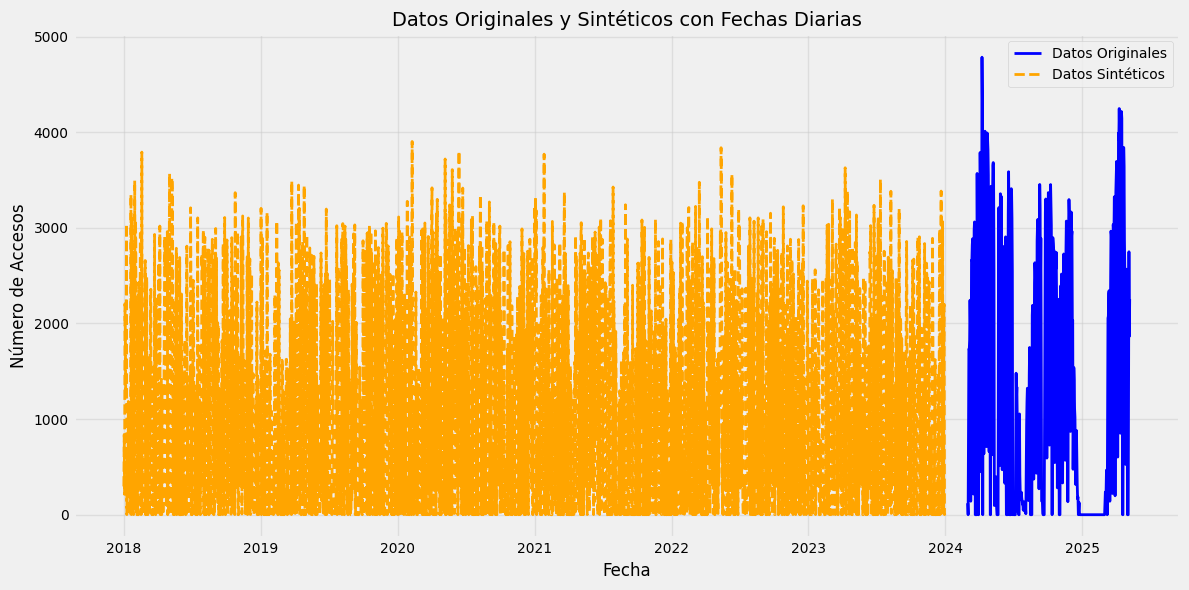

In [13]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

# Entrenar el modelo Random Forest
X_train_rf = X_train.copy()  # Usamos las características existentes
y_train_rf = y_train.copy()  # Usamos los valores reales de 'Accesos'

# Crear y entrenar el modelo
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

# Crear datos sintéticos para fechas anteriores (2023 hacia atrás)
# Generamos características similares a las existentes
synthetic_start_date = '2018-01-01'
synthetic_end_date = '2023-12-31'
synthetic_dates = pd.date_range(start=synthetic_start_date, end=synthetic_end_date, freq='D')  # Frecuencia diaria

synthetic_data = []

for date in synthetic_dates:
    year = date.year
    month = date.month
    day = date.day
    # Crear características sintéticas
    synthetic_row = {
        'Fecha': date,
        'Año': year,
        'Mes': month,
        'Día': day,
        'Vacaciones': np.random.choice([0, 1]),  # Vacaciones aleatorias
        'lag_7': np.random.uniform(X_train_rf['lag_7'].min(), X_train_rf['lag_7'].max()),
        'lag_14': np.random.uniform(X_train_rf['lag_14'].min(), X_train_rf['lag_14'].max()),
        'lag_21': np.random.uniform(X_train_rf['lag_21'].min(), X_train_rf['lag_21'].max()),
        'Semestre': 1 if 3 <= month <= 7 else (2 if 8 <= month <= 12 else 0),  # Semestre basado en el mes
        'Semana_Certamen': np.random.choice([0, 1])  # Certamen aleatorio
    }
    synthetic_data.append(synthetic_row)

# Convertir los datos sintéticos en un DataFrame
synthetic_df = pd.DataFrame(synthetic_data)

# Predecir los valores de 'Accesos' para los datos sintéticos
synthetic_df['Accesos'] = rf_model.predict(synthetic_df[['Vacaciones', 'lag_7', 'lag_14', 'lag_21', 'Semestre', 'Semana_Certamen']])

# Combinar los datos originales con los sintéticos
augmented_data = pd.concat([synthetic_df,daily_counts_full], ignore_index=True)

# Guardar los datos aumentados en un archivo Excel
augmented_data.to_excel("augmented_data_with_daily_dates.xlsx", index=False)
print("Datos aumentados con fechas diarias guardados en 'augmented_data_with_daily_dates.xlsx'")

# Graficar los datos originales y sintéticos con fechas diarias
plt.figure(figsize=(12, 6))

# Graficar los datos originales
plt.plot(daily_counts_full['Fecha'], daily_counts_full['Accesos'], label='Datos Originales', color='blue', linewidth=2)

# Graficar los datos sintéticos
plt.plot(synthetic_df['Fecha'], synthetic_df['Accesos'], label='Datos Sintéticos', color='orange', linestyle='--', linewidth=2)

# Configurar el gráfico
plt.title('Datos Originales y Sintéticos con Fechas Diarias', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Número de Accesos', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

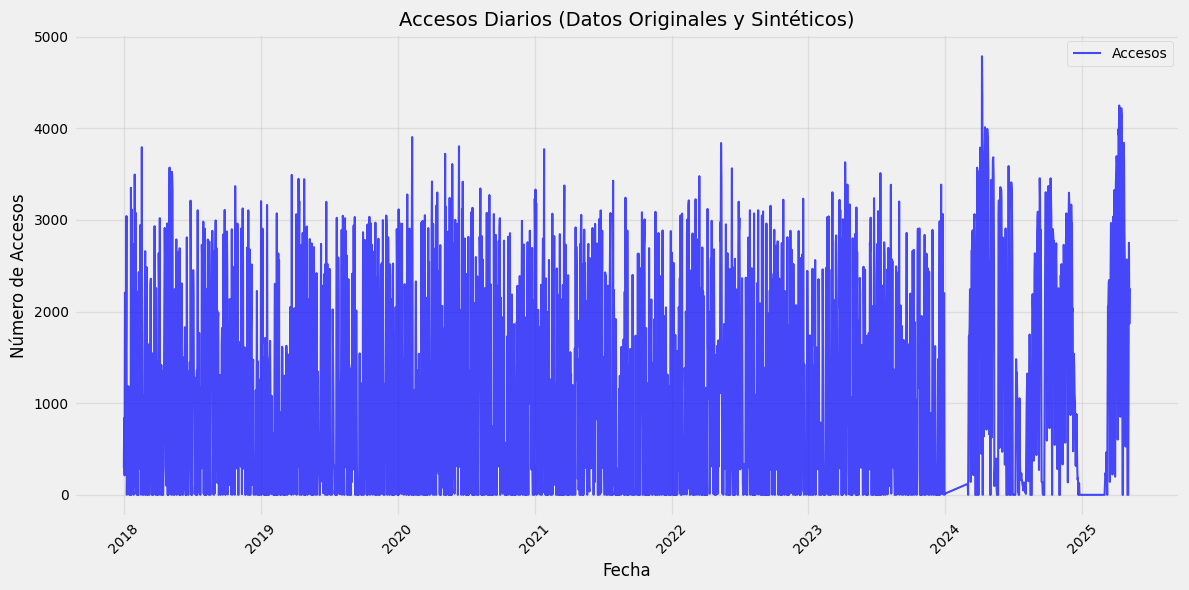

In [14]:
import matplotlib.pyplot as plt

# Asegúrate de que la columna 'Fecha' esté en formato datetime
augmented_data['Fecha'] = pd.to_datetime(augmented_data['Fecha'])

# Ordenar los datos por fecha
augmented_data = augmented_data.sort_values(by='Fecha')

# Graficar los accesos diarios
plt.figure(figsize=(12, 6))
plt.plot(augmented_data['Fecha'], augmented_data['Accesos'], label='Accesos', color='blue', alpha=0.7)

# Configuración del gráfico
plt.title('Accesos Diarios (Datos Originales y Sintéticos)', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Número de Accesos', fontsize=12)
plt.xticks(rotation=45)
plt.grid(alpha=0.5)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

## División de datos de entrenamiento y test


In [15]:
from sklearn.model_selection import train_test_split

for lag in [7, 14, 21]:
    daily_counts_full[f'lag_{lag}'] = daily_counts_full['Accesos'].shift(lag)

# Elimina las filas con NaN generadas por el shift
daily_counts_full = daily_counts_full.dropna().reset_index(drop=True)

# Incluye los lags en X
X = daily_counts_full[['Vacaciones', 'lag_7', 'lag_14', 'lag_21', 'Semestre', 'Semana_Certamen']]
y = daily_counts_full['Accesos']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True
)

print(f"Datos de entrenamiento: {len(X_train)}")
print(f"Datos de prueba: {len(X_test)}")

Datos de entrenamiento: 239
Datos de prueba: 60


## Crear modelo


In [16]:
model = xgb.XGBRegressor(
    objective ='reg:squarederror', 
    learning_rate = 0.3, 
    max_depth = 3, 
    n_estimators = 100
    )
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.3, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [17]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
tscv = TimeSeriesSplit(n_splits=5)
# Definir el espacio de búsqueda
param_grid = {
    'n_estimators': [50, 100, 250,500],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 8, 15],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}
# Grid Search con TimeSeriesSplit
grid_search = GridSearchCV(
    xgb.XGBRegressor(),
    param_grid, 
    cv=tscv, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
print(f'Mejores parámetros: {grid_search.best_params_}')

Mejores parámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250, 'subsample': 0.8}


In [18]:
model = xgb.XGBRegressor(
    colsample_bytree = 0.8,
    objective ='reg:squarederror', 
    learning_rate = 0.01, 
    max_depth = 3, 
    n_estimators = 250,
    subsample = 0.8
    )
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=250,
             n_jobs=None, num_parallel_tree=None, ...)

## Evaluación de rendimiento

In [19]:
predicted = model.predict(X_test)

In [20]:
predicted

array([1243.3037 , 1887.9972 , 1215.041  , 1770.2186 , 2450.5435 ,
       2884.1755 ,  332.36218, 1781.903  , 2355.704  , 1477.2802 ,
        335.9271 , 2702.7886 , 1902.7489 , 2250.0547 , 1439.6616 ,
       1799.3496 , 1293.6643 , 1635.418  , 1846.7446 , 2475.7344 ,
       1527.7699 , 1505.6401 , 2761.6497 ,  685.7428 , 1921.5961 ,
        479.84332, 1767.2577 , 2810.473  , 1549.583  , 1488.1046 ,
       2650.2097 , 1827.5353 , 2268.3953 ,  358.83093, 1058.9608 ,
       2227.0645 , 1576.9425 , 1687.905  , 1456.077  , 1783.0024 ,
       2670.7974 , 1844.0297 ,  303.86743, 1879.047  , 2439.2104 ,
       1506.9586 , 1855.0299 , 2210.8713 , 2136.9077 , 2390.3867 ,
       1266.8789 ,  364.57977, 1933.8134 , 1702.9376 , 1518.1272 ,
        431.8434 , 2487.1626 , 1482.1938 , 1841.527  , 1949.0371 ],
      dtype=float32)

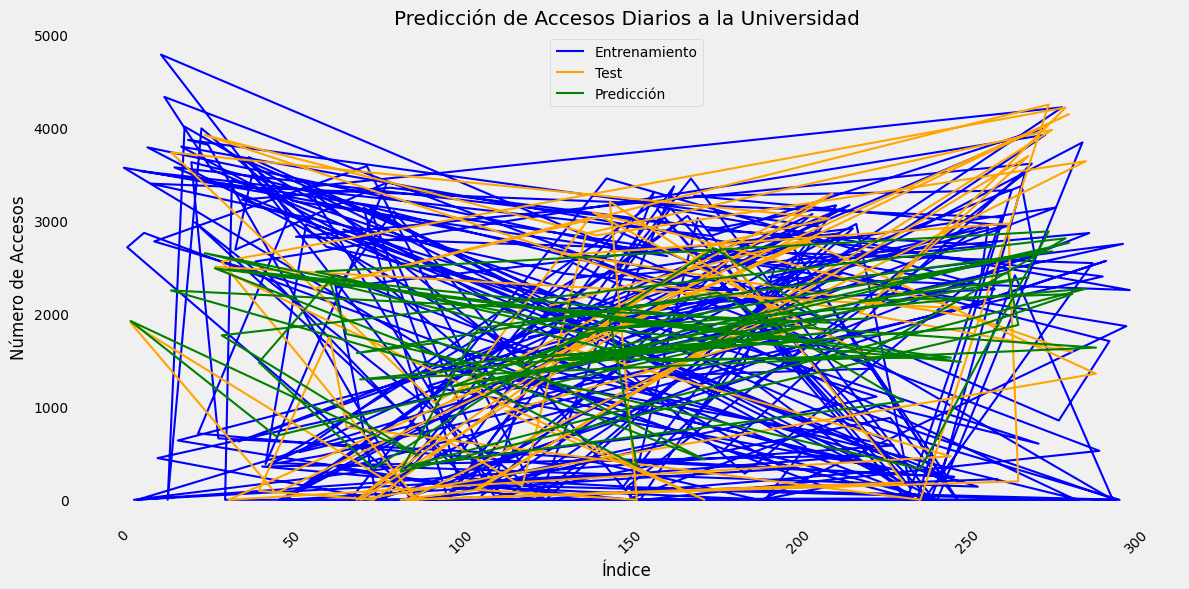

Error Cuadrático Medio (MSE): 989367.19
Error Absoluto Medio (MAE): 842.05
Error Porcentual Absoluto Medio (SMAPE): 78.35%


In [21]:
# Graficar resultados y calcular métricas para XGBoost
plt.figure(figsize=(12, 6))
plt.plot(X_train.index, y_train, label='Entrenamiento', color='blue')
plt.plot(X_test.index, y_test, label='Test', color='orange')
plt.plot(X_test.index, predicted, label='Predicción', color='green')
plt.title('Predicción de Accesos Diarios a la Universidad')
plt.xlabel('Índice')
plt.ylabel('Número de Accesos')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Evaluación del modelo
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test, predicted)
mae = mean_absolute_error(y_test, predicted)
smape_value = smape(y_test, predicted)
print(f"Error Cuadrático Medio (MSE): {mse:.2f}")
print(f"Error Absoluto Medio (MAE): {mae:.2f}")
print(f"Error Porcentual Absoluto Medio (SMAPE): {smape_value:.2f}%")

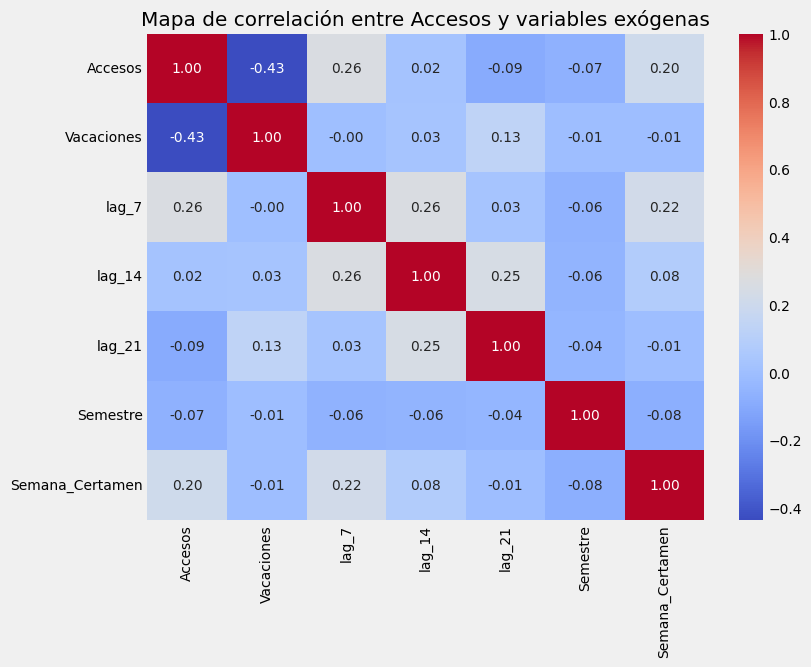

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Selecciona solo las columnas numéricas relevantes
corr_df = daily_counts_full[['Accesos', 'Vacaciones', 'lag_7', 'lag_14', 'lag_21', 'Semestre', 'Semana_Certamen']].copy()

# Calcula la matriz de correlación
corr_matrix = corr_df.corr()

# Mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de correlación entre Accesos y variables exógenas')
plt.show()

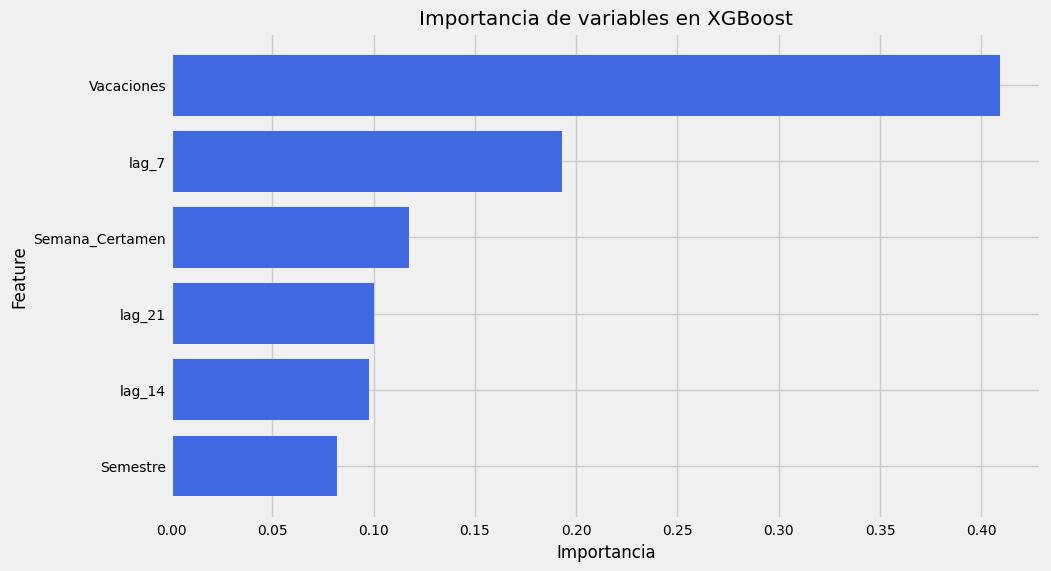

In [22]:
import matplotlib.pyplot as plt

# Obtener importancia de las características
importances = model.feature_importances_

# Usar las columnas de X_train como nombres de las variables
features = X_train.columns
importance_df = pd.DataFrame({"Feature": features, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='royalblue')
plt.xlabel("Importancia")
plt.ylabel("Feature")
plt.title("Importancia de variables en XGBoost")
plt.gca().invert_yaxis()  # Para que la más importante aparezca arriba
plt.show()

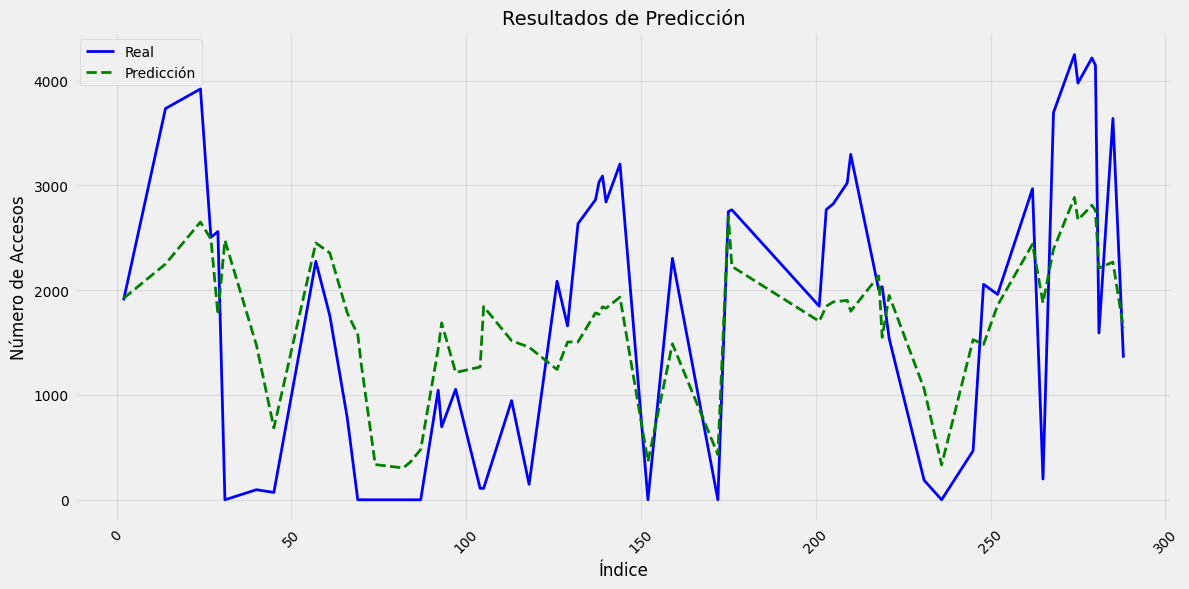

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Crear un DataFrame con los resultados
results_df = pd.DataFrame({
    'Índice': X_test.index,
    'Real': y_test,
    'Predicción': predicted
}).sort_values(by='Índice')  # Ordenar por índice

# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(results_df['Índice'], results_df['Real'], label='Real', color='blue', linewidth=2)
plt.plot(results_df['Índice'], results_df['Predicción'], label='Predicción', color='green', linestyle='--', linewidth=2)
plt.title('Resultados de Predicción', fontsize=14)
plt.xlabel('Índice', fontsize=12)
plt.ylabel('Número de Accesos', fontsize=12)
plt.xticks(rotation=45)
plt.legend(fontsize=10)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()